In [1]:
from metaflow import Flow

In [391]:
run = Flow('ExpandPaginate').latest_successful_run

In [392]:
pages_df = run.data.pages

In [393]:
import seaborn as sns
sns.set()
sns.set_palette(sns.color_palette("RdBu_r", 7))

In [394]:
pages_df['words'] = pages_df['text'].map(lambda x: x['words'])
pages_df['unknownIndices'] = pages_df['text'].map(lambda x: x['unknownIndices'])
pages_df['unknownWords'] = pages_df['text'].map(lambda x: x['unknownWords'])
pages_df['unknownIndices'] = pages_df['text'].map(lambda x: x['unknownIndices'])
pages_df = pages_df.loc[pages_df['eltime'] != 0]

pages_df['wpm'] = len(pages_df['words'])/(pages_df['eltime']/1000/60)

In [395]:
from gorani.utils import parse_ts
pages_df['time'] = pages_df['time'].map(lambda x: parse_ts(x))

In [396]:
pages_df = pages_df.sort_values(['time'])
pages_df['i'] = pages_df.sort_values(['time']).groupby('userId').cumcount() + 1

In [397]:
pages_df['words2'] = pages_df['words'].map(lambda x: ' '.join(x))

In [398]:
import pandas as pd
words2_df = pd.DataFrame(pages_df['words2'].unique(), columns=['words2'])
words2_df = words2_df.reset_index()
words2_df = words2_df.rename(columns={'index': 'id'})

In [399]:
df = words2_df.join(pages_df.set_index('words2'), on='words2')

In [400]:
def clsuter(rows):
    out = []
    tmp = 0
    for t in rows['time']:
        if tmp == 0:
            tmp = t
        out.append(t - tmp)
        
    return pd.DataFrame({'dt':out})

df = df.sort_values(['time']).groupby(['userId', 'id']).apply(clsuter)

In [401]:
df = df.loc[df['dt'] != 0]

In [402]:
df = df.loc[df['dt'] < 24*60*60]

In [403]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(df['dt'].to_numpy().reshape(-1,1))

df2 = pd.DataFrame({'dt':df['dt'], 'cluster':kmeans.labels_.tolist()})

In [404]:
df2['dt'] /= 60

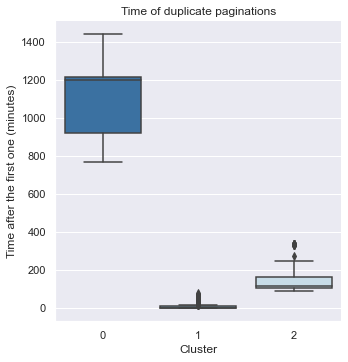

In [405]:
ax = sns.catplot(x="cluster", y="dt", kind="box", data=df2)
ax.set(xlabel='Cluster', ylabel='Time after the first one (minutes)', title='Time of duplicate paginations')


In [406]:
df2.groupby('cluster').describe()

dt                                                                \
          count         mean         std         min         25%          50%   
cluster                                                                         
0          62.0  1130.762366  217.491184  768.516667  916.941667  1196.125000   
1        1803.0     6.632751   12.934952    0.016667    0.116667     0.600000   
2         151.0   155.749338   83.472676   85.433333  104.475000   114.983333   

                                   
                 75%          max  
cluster                            
0        1212.695833  1438.550000  
1           6.300000    78.166667  
2         162.158333   336.033333

In [407]:
pages_df['eltime'] /= 1000
pages_df['wpm'] = pages_df.apply(lambda x: len(x['words'])/x['eltime']*60, axis=1)

In [411]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(pages_df['wpm'].to_numpy().reshape(-1,1))

df2 = pd.DataFrame({'wpm':pages_df['wpm'], 'cluster':kmeans.labels_.tolist()})

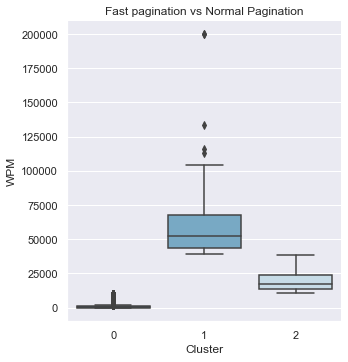

In [412]:
ax = sns.catplot(x="cluster", y="wpm", kind="box", data=df2)
ax.set(xlabel='Cluster', ylabel='WPM', title='Fast pagination vs Normal Pagination')

In [413]:
df2.groupby('cluster').describe()

wpm                                                          \
           count          mean           std           min           25%   
cluster                                                                    
0        12898.0   1220.157722   2449.799279      0.000000     76.076555   
1          229.0  58250.842725  21453.499702  39066.666667  43350.000000   
2         1953.0  19472.229167   7059.296443  10350.000000  13700.000000   

                                               
                  50%      75%            max  
cluster                                        
0          100.746269    900.0   10329.113924  
1        52200.000000  67800.0  199800.000000  
2        17640.000000  24200.0   38700.000000

In [ ]:
7.603361e+04